# Initialisation

In [1]:
import pandas as pd
import re
import kagglehub
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report


# Description des données

Nous utilisons un jeu de données contenant plus de 23 000 tweets collectés entre 2021 et novembre 2022. Chaque ligne représente un tweet et comporte plusieurs colonnes :

Date : la date et l’heure de publication du tweet

Username : le nom d’utilisateur ayant posté le tweet

Content : le texte brut du tweet

URL : lien vers le tweet (souvent vide)

Hashtags : hashtags associés (parfois absents)

Notre objectif est d’analyser spécifiquement les tweets qui évoquent les crypto-monnaies via des symboles de type $BTC, $ETH, etc.

Après nettoyage, nous extrayons les mentions de cryptos et conservons uniquement les plus pertinentes (en écartant les valeurs monétaires comme $5, $100 qui ne sont pas des cryptos).

Quelles sont les crypto-monnaies les plus discutées sur Twitter, et peut-on évaluer le sentiment associé à ces mentions ?

Nous cherchons à concevoir un assistant virtuel capable de :

Identifier les cryptos les plus populaires dans le corpus Twitter

Explorer les exemples de tweets positifs et négatifs par crypto

Estimer la répartition du sentiment pour chaque crypto

Visualiser les mots les plus fréquents pour chaque tendance (wordcloud)

L’objectif final est de proposer un outil interactif pour surveiller la perception sociale des cryptos en temps réel à partir de données Twitter.

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()  # upload ton kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d leoth9/crypto-tweets

!unzip -o crypto-tweets.zip

Dataset URL: https://www.kaggle.com/datasets/leoth9/crypto-tweets
License(s): CC0-1.0
  0% 0.00/1.19M [00:00<?, ?B/s]
100% 1.19M/1.19M [00:00<00:00, 116MB/s]
Archive:  crypto-tweets.zip
  inflating: crypto_10k_tweets_(2021_2022Nov).csv  


In [4]:
df = pd.read_csv(
    "crypto_10k_tweets_(2021_2022Nov).csv",
    engine='python',         # parser plus tolérant
    quoting=csv.QUOTE_NONE,  # éviter les problèmes de guillemets
    encoding='utf-8',
    on_bad_lines='skip'      # ignore les lignes mal formées
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23121 entries, 0 to 23120
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  23120 non-null  object
 1   Date        11128 non-null  object
 2   Username    10126 non-null  object
 3   Content     9041 non-null   object
 4   URL         3569 non-null   object
 5   Hashtags    2173 non-null   object
dtypes: object(6)
memory usage: 1.1+ MB


,Unnamed: 0,Date,Username,Content,URL,Hashtags
0,0,2022-11-30 11:53:21+00:00,0xEthereumYoda,"""#Ethereum price update:",None,None
1,#ETH $1269.23 USD,None,None,None,None,None
2,#Bitcoin 0.07510228 #BTC,None,None,None,None,None
3,Follow for recent ETH price updates,None,None,None,None,None
4,1,2022-11-30 11:53:21+00:00,Lawrenc32984128,"""@mtmalinen @ecb Do well to understand that ev...",None,None


In [5]:
df = df[['Date', 'Username', 'Content']]
df = df.dropna(subset=['Content'])  # supprimer les lignes sans texte
df = df.reset_index(drop=True)

In [6]:
df

,Date,Username,Content
0,2022-11-30 11:53:21+00:00,0xEthereumYoda,"""#Ethereum price update:"
1,2022-11-30 11:53:21+00:00,Lawrenc32984128,"""@mtmalinen @ecb Do well to understand that ev..."
2,you‘ll know to do: Buy,HODL,Be patient.
3,2022-11-30 11:53:20+00:00,817coin,#Bitcoin https://t.co/2koLlCvCri https://t.co/...
4,2022-11-30 11:53:18+00:00,slamtoken,"""Yesterday we made a 3"
...,...,...,...
9036,2022-11-30 09:16:43+00:00,tecniaofficial,"""Digital Rupee or e-Rupee is a form of digital..."
9037,2022-11-30 09:16:41+00:00,BullshitTrader_,"""In bear market"
9038,https://twitter.com/BullshitTrader_/status/159...,"""['btc'",'bitcoin'
9039,2022-11-30 09:16:40+00:00,rektBart,Take that high and I’m max short #btc https://...


In [7]:
# Fonction d'extraction des symboles type $BTC, $ETH...
def extract_cryptos(text):
    return re.findall(r"\$[A-Za-z0-9]+", str(text))
df['cryptos'] = df['Content'].apply(extract_cryptos)

In [8]:
df

,Date,Username,Content,cryptos
0,2022-11-30 11:53:21+00:00,0xEthereumYoda,"""#Ethereum price update:",[]
1,2022-11-30 11:53:21+00:00,Lawrenc32984128,"""@mtmalinen @ecb Do well to understand that ev...",[]
2,you‘ll know to do: Buy,HODL,Be patient.,[]
3,2022-11-30 11:53:20+00:00,817coin,#Bitcoin https://t.co/2koLlCvCri https://t.co/...,[]
4,2022-11-30 11:53:18+00:00,slamtoken,"""Yesterday we made a 3",[]
...,...,...,...,...
9036,2022-11-30 09:16:43+00:00,tecniaofficial,"""Digital Rupee or e-Rupee is a form of digital...",[]
9037,2022-11-30 09:16:41+00:00,BullshitTrader_,"""In bear market",[]
9038,https://twitter.com/BullshitTrader_/status/159...,"""['btc'",'bitcoin',[]
9039,2022-11-30 09:16:40+00:00,rektBart,Take that high and I’m max short #btc https://...,[]


In [9]:
valid_crypto_symbols = {
    "$BTC", "$ETH", "$BNB", "$USDT", "$USDC", "$XRP", "$ADA",
    "$SOL", "$DOGE", "$DOT", "$MATIC", "$AVAX", "$TRX", "$LINK",
    "$LTC", "$SHIB", "$ETC", "$XLM", "$ICP", "$FIL", "$APT",
    "$AR", "$NEAR", "$VET", "$HBAR", "$EGLD", "$TON", "$OP",
    "$PEPE", "$SUI", "$UNI", "$AAVE", "$XMR", "$RUNE", "$CAKE",
    "$FTM", "$LUNA", "$RISE"
}

from collections import Counter
# Ne garder que les cryptos valides
df['cryptos'] = df['cryptos'].apply(lambda lst: [c for c in lst if c in valid_crypto_symbols])

# Recompter les mentions
filtered_cryptos = sum(df['cryptos'], [])
top_valid_cryptos = Counter(filtered_cryptos).most_common(10)

# Affichage
print("Top 10 des vraies crypto-monnaies les plus mentionnées :")
for i, (crypto, count) in enumerate(top_valid_cryptos, 1):
    print(f"{i}. {crypto} — {count} mentions")



Top 10 des vraies crypto-monnaies les plus mentionnées :
1. $BTC — 126 mentions
2. $BNB — 94 mentions
3. $RISE — 38 mentions
4. $ETH — 31 mentions
5. $USDT — 29 mentions
6. $SOL — 6 mentions
7. $SHIB — 6 mentions
8. $LINK — 5 mentions
9. $ADA — 5 mentions
10. $AVAX — 5 mentions


In [10]:
df

,Date,Username,Content,cryptos
0,2022-11-30 11:53:21+00:00,0xEthereumYoda,"""#Ethereum price update:",[]
1,2022-11-30 11:53:21+00:00,Lawrenc32984128,"""@mtmalinen @ecb Do well to understand that ev...",[]
2,you‘ll know to do: Buy,HODL,Be patient.,[]
3,2022-11-30 11:53:20+00:00,817coin,#Bitcoin https://t.co/2koLlCvCri https://t.co/...,[]
4,2022-11-30 11:53:18+00:00,slamtoken,"""Yesterday we made a 3",[]
...,...,...,...,...
9036,2022-11-30 09:16:43+00:00,tecniaofficial,"""Digital Rupee or e-Rupee is a form of digital...",[]
9037,2022-11-30 09:16:41+00:00,BullshitTrader_,"""In bear market",[]
9038,https://twitter.com/BullshitTrader_/status/159...,"""['btc'",'bitcoin',[]
9039,2022-11-30 09:16:40+00:00,rektBart,Take that high and I’m max short #btc https://...,[]


Barplot des mentions de cryptos

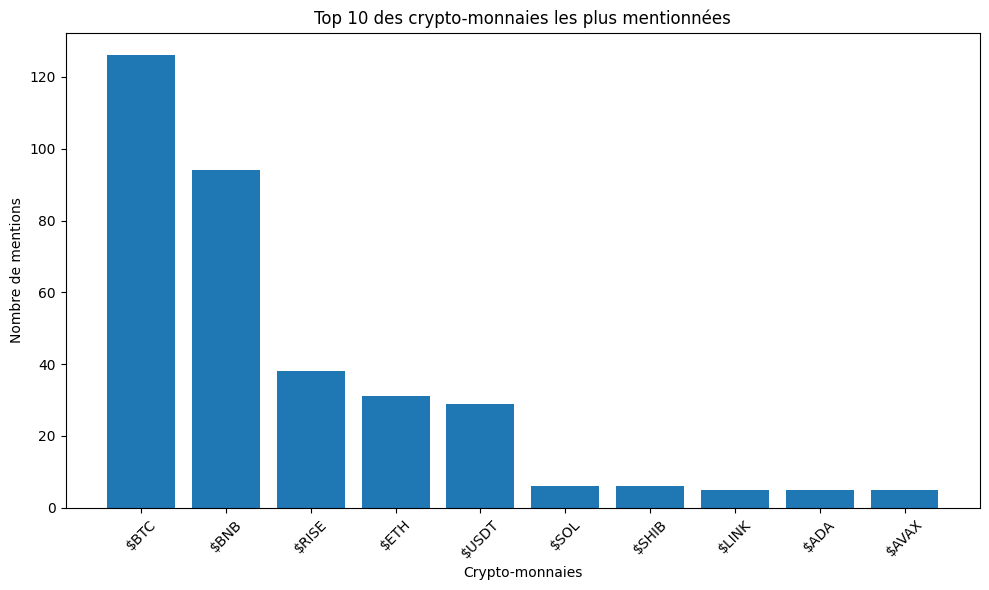

In [11]:
# Données pour le plot
cryptos, counts = zip(*top_valid_cryptos)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(cryptos, counts)
plt.xlabel("Crypto-monnaies")
plt.ylabel("Nombre de mentions")
plt.title("Top 10 des crypto-monnaies les plus mentionnées")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd

# Ton dictionnaire de mots-clés
crypto_keywords = {
    "$BTC": ["$BTC", "#BTC", "btc", "bitcoin"],
    "$ETH": ["$ETH", "#ETH", "eth ", "ethereum"],
    "$BNB": ["$BNB", "#BNB", "bnb", "binance coin"],
    "$USDT": ["$USDT", "#USDT", "usdt", "tether"],
    "$USDC": ["$USDC", "#USDC", "usdc", "usd coin"],
    "$XRP": ["$XRP", "#XRP", "xrp", "ripple"],
    "$ADA": ["$ADA", "#ADA", "ada ", "cardano"],
    "$SOL": ["$SOL", "#SOL", "sol ", "solana"],
    "$DOGE": ["$DOGE", "#DOGE", "doge ", "dogecoin"],
    "$DOT": ["$DOT", "#DOT", "dot ", "polkadot"],
    "$MATIC": ["$MATIC", "#MATIC", "matic", "polygon"],
    "$AVAX": ["$AVAX", "#AVAX", "avax", "avalanche"],
    "$TRX": ["$TRX", "#TRX", "trx", "tron"],
    "$LINK": ["$LINK", "#LINK", "link", "chainlink"],
    "$LTC": ["$LTC", "#LTC", "ltc", "litecoin"],
    "$SHIB": ["$SHIB", "#SHIB", "shib", "shiba inu"],
    "$ETC": ["$ETC", "#ETC", "etc", "ethereum classic"],
    "$XLM": ["$XLM", "#XLM", "xlm", "stellar"],
    "$ICP": ["$ICP", "#ICP", "icp ", "internet computer"],
    "$FIL": ["$FIL", "#FIL", "fil ", "filecoin"],
    "$APT": ["$APT", "#APT", "apt ", "aptos"],
    "$AR": ["$AR", "#AR", "ar ", "arweave"],
    "$NEAR": ["$NEAR", "#NEAR", "near "],
    "$VET": ["$VET", "#VET", "vet ", "vechain"],
    "$HBAR": ["$HBAR", "#HBAR", "hbar ", "hedera"],
    "$EGLD": ["$EGLD", "#EGLD", "egld", "multiversx"],
    "$TON": ["$TON", "#TON", "ton ", "toncoin"],
    "$OP": ["$OP", "#OP", "op ", "optimism"],
    "$PEPE": ["$PEPE", "#PEPE", "pepe"],
    "$SUI": ["$SUI", "#SUI", "sui "],
    "$UNI": ["$UNI", "#UNI", "uni ", "uniswap"],
    "$AAVE": ["$AAVE", "#AAVE", "aave"],
    "$XMR": ["$XMR", "#XMR", "xmr", "monero"],
    "$RUNE": ["$RUNE", "#RUNE", "rune ", "thorchain"],
    "$CAKE": ["$CAKE", "#CAKE", "cake ", "pancakeswap"],
    "$FTM": ["$FTM", "#FTM", "ftm", "fantom "],
    "$LUNA": ["$LUNA", "#LUNA", "luna ", "terra "],
    "$RISE": ["$RISE", "#RISE", "rise"]
}

# Fonction pour détecter toutes les cryptos dans un texte
def detect_cryptos_in_text(text):
    text = text.lower()
    detected = []
    for symbol, variants in crypto_keywords.items():
        if any(v.lower() in text for v in variants):
            detected.append(symbol)
    return list(set(detected)) if detected else None

# Application sur le DataFrame
df['cryptos'] = df['Content'].apply(detect_cryptos_in_text)
df = df[df['cryptos'].notnull()].reset_index(drop=True)

# Décomposer chaque ligne en plusieurs lignes
df_exploded = df.explode('cryptos').reset_index(drop=True)

# Résultat final
df_final = df_exploded[['Date', 'Username', 'Content', 'cryptos']]

def extract_exact_mention(text, crypto):
    variants = crypto_keywords.get(crypto, [])
    text = text.lower()
    for v in variants:
        if v.lower() in text:
            return v.lower()
    return None

df_final['mention'] = df_final.apply(lambda row: extract_exact_mention(row['Content'], row['cryptos']), axis=1)


In [13]:
df_final

,Date,Username,Content,cryptos,mention
0,2022-11-30 11:53:21+00:00,0xEthereumYoda,"""#Ethereum price update:",$ETH,#eth
1,2022-11-30 11:53:21+00:00,Lawrenc32984128,"""@mtmalinen @ecb Do well to understand that ev...",$BTC,#btc
2,2022-11-30 11:53:20+00:00,817coin,#Bitcoin https://t.co/2koLlCvCri https://t.co/...,$BTC,bitcoin
3,https://twitter.com/slamtoken/status/159792171...,"""['slamtoken'",'bnb',$BNB,bnb
4,2022-11-30 11:53:15+00:00,blockchankhick,"""The LARGEST DROP IN YEARS. Good to see sentim...",$OP,op
...,...,...,...,...,...
4697,2022-11-30 09:16:47+00:00,kubatsky,"""#BTC played out perfectly.",$BTC,#btc
4698,2022-11-30 09:16:41+00:00,BullshitTrader_,"""In bear market",$AR,ar
4699,https://twitter.com/BullshitTrader_/status/159...,"""['btc'",'bitcoin',$BTC,bitcoin
4700,2022-11-30 09:16:40+00:00,rektBart,Take that high and I’m max short #btc https://...,$BTC,#btc


In [14]:
ind = list(df_final.cryptos.value_counts().index)
vals = list(df_final.cryptos.value_counts())

result = '  '.join([f"{i} == {v}" for i, v in zip(ind, vals)])
print(result)



$BTC == 2207  $ETH == 440  $BNB == 328  $TRX == 271  $AR == 225  $USDC == 221  $OP == 190  $USDT == 189  $AVAX == 82  $LTC == 82  $RISE == 68  $LINK == 62  $ADA == 52  $DOGE == 37  $SHIB == 35  $SOL == 35  $MATIC == 33  $XRP == 29  $NEAR == 17  $UNI == 15  $FTM == 15  $ETC == 12  $LUNA == 10  $DOT == 8  $PEPE == 7  $AAVE == 5  $TON == 4  $XLM == 4  $XMR == 4  $APT == 3  $CAKE == 2  $FIL == 2  $SUI == 2  $EGLD == 2  $ICP == 1  $VET == 1  $HBAR == 1  $RUNE == 1


In [15]:
!pip install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=d58126c5a4a3f53f8c017b99155cb0eec5094ed1a2aa944ec4e10ca654dbcbf2
  Stored in directory: /root/.cache/pip/wheels/b7/23/31/f9b93f25b95da9b91729c4cd5f35a2b692ab06f688f6759630
Successfully built emoji


In [16]:
df.columns

Index(['Date', 'Username', 'Content', 'cryptos'], dtype='object')

In [17]:
df.to_csv('dataframe.csv')

# **ANALYSE DE SENTIMENT**

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import pandas as pd

# Charger modèle
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

labels = ['negative', 'neutral', 'positive']

def analyze_sentiment_bert(tweet_text):
    inputs = tokenizer(tweet_text, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        score, prediction = torch.max(probs, 1)
        return labels[prediction.item()], round(score.item(), 3)

# Appliquer à chaque ligne
df_final[['sentiment', 'confidence']] = df_final['Content'].apply(lambda x: pd.Series(analyze_sentiment_bert(x)))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [19]:
df_final

,Date,Username,Content,cryptos,mention,sentiment,confidence
0,2022-11-30 11:53:21+00:00,0xEthereumYoda,"""#Ethereum price update:",$ETH,#eth,neutral,0.882
1,2022-11-30 11:53:21+00:00,Lawrenc32984128,"""@mtmalinen @ecb Do well to understand that ev...",$BTC,#btc,positive,0.819
2,2022-11-30 11:53:20+00:00,817coin,#Bitcoin https://t.co/2koLlCvCri https://t.co/...,$BTC,bitcoin,neutral,0.885
3,https://twitter.com/slamtoken/status/159792171...,"""['slamtoken'",'bnb',$BNB,bnb,neutral,0.732
4,2022-11-30 11:53:15+00:00,blockchankhick,"""The LARGEST DROP IN YEARS. Good to see sentim...",$OP,op,negative,0.664
...,...,...,...,...,...,...,...
4697,2022-11-30 09:16:47+00:00,kubatsky,"""#BTC played out perfectly.",$BTC,#btc,positive,0.807
4698,2022-11-30 09:16:41+00:00,BullshitTrader_,"""In bear market",$AR,ar,negative,0.569
4699,https://twitter.com/BullshitTrader_/status/159...,"""['btc'",'bitcoin',$BTC,bitcoin,neutral,0.795
4700,2022-11-30 09:16:40+00:00,rektBart,Take that high and I’m max short #btc https://...,$BTC,#btc,neutral,0.838


In [20]:
def analyze_sentiment_prompt(tweet_text, crypto):
    prompt = f"In this tweet: '{tweet_text}', the sentiment toward {crypto} is:"
    return analyze_sentiment_bert(prompt)  # réutilise la fonction du Code 1

df_final[['sentiment', 'score']] = df_final.apply(
    lambda row: pd.Series(analyze_sentiment_prompt(row['Content'], row['mention'])), axis=1
)


In [21]:
df_final

,Date,Username,Content,cryptos,mention,sentiment,confidence,score
0,2022-11-30 11:53:21+00:00,0xEthereumYoda,"""#Ethereum price update:",$ETH,#eth,neutral,0.882,0.829
1,2022-11-30 11:53:21+00:00,Lawrenc32984128,"""@mtmalinen @ecb Do well to understand that ev...",$BTC,#btc,positive,0.819,0.716
2,2022-11-30 11:53:20+00:00,817coin,#Bitcoin https://t.co/2koLlCvCri https://t.co/...,$BTC,bitcoin,neutral,0.885,0.880
3,https://twitter.com/slamtoken/status/159792171...,"""['slamtoken'",'bnb',$BNB,bnb,neutral,0.732,0.815
4,2022-11-30 11:53:15+00:00,blockchankhick,"""The LARGEST DROP IN YEARS. Good to see sentim...",$OP,op,negative,0.664,0.515
...,...,...,...,...,...,...,...,...
4697,2022-11-30 09:16:47+00:00,kubatsky,"""#BTC played out perfectly.",$BTC,#btc,positive,0.807,0.851
4698,2022-11-30 09:16:41+00:00,BullshitTrader_,"""In bear market",$AR,ar,neutral,0.569,0.638
4699,https://twitter.com/BullshitTrader_/status/159...,"""['btc'",'bitcoin',$BTC,bitcoin,neutral,0.795,0.866
4700,2022-11-30 09:16:40+00:00,rektBart,Take that high and I’m max short #btc https://...,$BTC,#btc,neutral,0.838,0.852


In [22]:
cryptos_analysis=df_final[['Date','cryptos','sentiment','score','confidence']]
cryptos_analysis

,Date,cryptos,sentiment,score,confidence
0,2022-11-30 11:53:21+00:00,$ETH,neutral,0.829,0.882
1,2022-11-30 11:53:21+00:00,$BTC,positive,0.716,0.819
2,2022-11-30 11:53:20+00:00,$BTC,neutral,0.880,0.885
3,https://twitter.com/slamtoken/status/159792171...,$BNB,neutral,0.815,0.732
4,2022-11-30 11:53:15+00:00,$OP,negative,0.515,0.664
...,...,...,...,...,...
4697,2022-11-30 09:16:47+00:00,$BTC,positive,0.851,0.807
4698,2022-11-30 09:16:41+00:00,$AR,neutral,0.638,0.569
4699,https://twitter.com/BullshitTrader_/status/159...,$BTC,neutral,0.866,0.795
4700,2022-11-30 09:16:40+00:00,$BTC,neutral,0.852,0.838


In [23]:
import pandas as pd

# Exemple : remplacer 'Date' par le nom réel de ta colonne
def clean_invalid_dates(df, column_name='Date'):
    # Convertit la colonne en datetime, les erreurs deviennent NaT
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce')

    # Supprime les lignes où la conversion a échoué (valeurs non valides)
    df_cleaned = df[df[column_name].notnull()].reset_index(drop=True)

    return df_cleaned

# Utilisation :
new_df = clean_invalid_dates(cryptos_analysis, 'Date')
new_df


/tmp/ipython-input-23-3555548912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_datetime(df[column_name], errors='coerce')


,Date,cryptos,sentiment,score,confidence
0,2022-11-30 11:53:21+00:00,$ETH,neutral,0.829,0.882
1,2022-11-30 11:53:21+00:00,$BTC,positive,0.716,0.819
2,2022-11-30 11:53:20+00:00,$BTC,neutral,0.880,0.885
3,2022-11-30 11:53:15+00:00,$OP,negative,0.515,0.664
4,2022-11-30 11:53:13+00:00,$BTC,neutral,0.859,0.892
...,...,...,...,...,...
3934,2022-11-30 09:16:48+00:00,$OP,neutral,0.807,0.651
3935,2022-11-30 09:16:47+00:00,$BTC,positive,0.851,0.807
3936,2022-11-30 09:16:41+00:00,$AR,neutral,0.638,0.569
3937,2022-11-30 09:16:40+00:00,$BTC,neutral,0.852,0.838


In [24]:
print(new_df.Date.min(),new_df.Date.max())

2022-11-30 09:16:38+00:00 2022-11-30 11:53:21+00:00


In [25]:
new_df.to_csv('tweet_analysis.csv')
df_final.to_csv('tweet_content_analysis.csv')

test


In [ ]:
!pip install -q tweepy tqdm

# 📚 Imports
import tweepy
import pandas as pd
from tqdm.notebook import tqdm

# 🔐 Authentification à l'API X
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAC6H2wEAAAAAU0pC6nSBDcJzKfFLdTRHS1P014o%3D5ZE8WhgyhNMDiNsIfaxyRz9i14l0DBeUhaxrOij00tvWNLpuIe"  # ⬅️ Remplace ceci par ton token

client = tweepy.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True)

# 🔝 Liste top 10 cryptos avec mots-clés
crypto_keywords = {
    "$BTC": ["$BTC", "#BTC", "btc", "bitcoin"],
    "$ETH": ["$ETH", "#ETH", "eth", "ethereum"],
    "$BNB": ["$BNB", "#BNB", "bnb", "binance coin"],
    "$XRP": ["$XRP", "#XRP", "xrp", "ripple"],
    "$SOL": ["$SOL", "#SOL", "sol", "solana"],
    "$DOGE": ["$DOGE", "#DOGE", "doge", "dogecoin"],
    "$ADA": ["$ADA", "#ADA", "ada", "cardano"],
    "$AVAX": ["$AVAX", "#AVAX", "avax", "avalanche"],
    "$DOT": ["$DOT", "#DOT", "dot", "polkadot"],
    "$MATIC": ["$MATIC", "#MATIC", "matic", "polygon"]
}

# Génère la requête OR
query_parts = [f'"{kw}"' for kws in crypto_keywords.values() for kw in kws]
query = "(" + " OR ".join(query_parts) + ") lang:en -is:retweet"

# Détecter quelle crypto est mentionnée
def detect_crypto(text):
    text_lower = text.lower()
    for code, kws in crypto_keywords.items():
        for kw in kws:
            if kw.lower() in text_lower:
                return code
    return None

# Collecte des tweets avec tqdm
tweets_data = []
MAX_TWEETS = 10_000
BATCH_SIZE = 100

# Calcul du nombre maximal d'itérations (approx)
max_iters = MAX_TWEETS // BATCH_SIZE

with tqdm(total=MAX_TWEETS, desc="Collecte tweets") as pbar:
    for response in tweepy.Paginator(
        client.search_recent_tweets,
        query=query,
        tweet_fields=["id", "created_at", "public_metrics", "text", "author_id"],
        expansions=["author_id"],
        user_fields=["username"],
        max_results=BATCH_SIZE,
        limit=max_iters
    ):
        users = {u["id"]: u["username"] for u in response.includes["users"]}
        for tweet in response.data:
            code = detect_crypto(tweet.text)
            if code:
                tweets_data.append({
                    "date": tweet.created_at,
                    "username": users.get(tweet.author_id, None),
                    "tweet": tweet.text,
                    "likes": tweet.public_metrics.get("like_count", 0),
                    "crypto": code
                })
        pbar.update(len(response.data))
        if len(tweets_data) >= MAX_TWEETS:
            break

# Création du DataFrame final
df = pd.DataFrame(tweets_data)
df = df.dropna(subset=["username"])  # sécurité
df.reset_index(drop=True, inplace=True)

print("✅ Extraction terminée. Taille:", len(df))
df.head(10)


Collecte tweets:   0%|          | 0/10000 [00:00<?, ?it/s]